# Intel&reg; OSPRay Introduction
--------



## Learning Objectives

* Define the goals of Intel® OSPRay.
* Summarize the program flow and OSPRay API use in the ospTutorial.cpp code.


***
### 1. Intel&reg; OSPRay overview

Intel OSPRay is an open source ray tracing engine for high-performance, high-fidelity visualization on Intel Architecture CPUs.  OSPRay is part of the Intel oneAPI Rendering Toolkit and is released under the permissive Apache 2.0 license.

<!-- The purpose of OSPRay is to provide an open, powerful, and easy-to-use rendering library that allows one to easily build applications that use ray tracing rendering for interactive applications, including both surface-based and volume-based visualizations. OSPRay is completely CPU-based, and runs on anything from laptops, to workstations, to compute nodes in HPC systems. -->

The purpose of OSPRay is to provide an easy-to-use rendering library that allows to easily build applications that use ray tracing rendering for interactive applications, including both surface-based and volume-based visualizations.

<!-- OSPRay internally builds on top of Intel Embree and Intel ISPC (Implicit SPMD Program Compiler), and fully exploits modern instruction sets like Intel SSE4, AVX, AVX2, AVX-512 and NEON to achieve high rendering performance, thus a CPU with support for at least SSE4.1 is required to run OSPRay on x86_64 architectures. -->

### 2. Intel&reg; OSPRay features

* **It is a library, not a visualization tool**. OSPRay is a _library_ that many different visualization tools can leverage.

* **A rendering solution for visualization tools**. Visualization tools often rely on middleware libraries (such as VTK). OSPRay does not replace such middleware, and focuses exclusively on the rendering component. This way OSPRay gives additional choices for rendering.

* **Focused on visualization rendering**. OSPRay emphasizes the rendering features needed for production and scientific visualization.

* **Focused on HPC visualization rendering**. We explicitly focus on problems that remain challenging for visualization applications, such as large data, volume rendering and advanced shading. In particular, we effectively perform rendering using HPC resources. The use of OSPRay with GPUs is coming soon!
<!-- * **Focused on performance**. Though we do not have to achieve game-like frame rates, our implementation makes efficient use of threading, vectorization, and, if desired, node-parallelism; and leverages the most efficient ray tracing technologies available. -->

### 3. Intel OSPRay API
The Intel OSPRay API is a layer between visualization applications and low-level hardware resources.
<!-- The figure below shows the Intel OSPRay API in relation to other hardware and software components commonly found in visualization applications. -->
The API is designed to be platform independent - this implementation targets CPUs, but the API should also map to GPUs, integrated graphics, and so on. It is a low level of abstraction similar to that of OpenGL*, which is the level that modern visualization tools use for rendering. Similar to solutions in OpenGL and GPGPU, Intel OSPRay API focuses on a low-level data model.

<img src="assets/Figure3.png" style="width:50%"></img>

### 4. API Categories
The OSPRay API exposes the following categories of objects:

* **OSPFrameBuffers** hold the final result of a rendered frame. Information held can contain, but is not limited to, pixel colors, depth values, and accumulation information.
* **OSPData** are 1D data arrays, similar to “buffers” in a GPGPU context. In addition to the typical scalar and 2-, 3-, or 4-dimensional vector data, data arrays can also contain references to other actors (including to other data arrays), in device-abstract fashion.
* **OSPGeometry** contain geometric surface primitives such as triangles, spheres, cylinders, etc.
* **OSPVolumes** represent 3D scalar fields that can produce, for any 3D position, a scalar value that a volume renderer can sample.
* **OSPTransferFunctions** map scalars to RGBA colors.
* **OSPModels** are collections of geometries and volumes – the parent objects of the hierarchy. Time-varying data are vectors of OSP- Models.
* **OSPCameras** generate primary rays for renderers to compute on.
* **OSPRenderers** use cameras, models, etc, to render pixels. OSPRay defines two renderers: 
    * `scivis` renderer that combines many rendering techniques into a single renderer. In this renderer we focus on the needs of scientific visualization: we implement an OpenGL-like material model, with customizable contributions of transparency, shadows, ambient occlusion, and fully integrated volume rendering.
    * `pathtracer` renderer, a fully photo-realistic renderer that can be used for generating high-quality publication images, and that has since seen adoption even outside of scientific visualization.
* **OSPLights, OSPTextures, and OSPMaterials** specify additional inputs for rendering, lighting, shading, etc.


#### Commit transactions
An important aspect OSPRay is that parameters/data that affect any of the objects get passedx using **ospCommit(object)**.

If a user wants to change the state of an existing object (e.g., to change the origin of an already existing camera) parameters have to be recommitted.

Commiting is important to ensure performance and consistency for devices crossing a PCI* bus, or across a network.


***
### 5. First Lesson: ospTutorial

In order to get a sense of basic API components we will work with the `ospTutorial.cpp` file which will create an image of two triangles, rendered with the pathtracer renderer.

The image `firstFrame.png` shows the result after one call to `ospRenderFrame`. Jagged edges and noise in the shadow can be seen. These are not incorrect renderings but are the result of the random nature of ray tracing. In future lessons we will learn how to address this issue with `ospRenderFrame` which will converge the resulting image.

#### 5.1 The Program Flow
The following is a general flow for the ospTutorial.cpp program. Although these steps are described for this program, they can be generalized for other OSPRay codes.

* Step 1 - Set up common objects to be used in the program
* Step 2 - Initialize the renderer using ospInit()
* Step 3 - Setup the camera and commit it
* Step 4 - Setup the scene
    * Step 4.1 - Feeding the model/vertex data to OSPRay
    * Step 4.2 - Create a material 
    * Step 4.3 - Put mesh into a model and apply material and release mesh
    * Step 4.4 - Put model into a group (collection of models), commit group and release model
    * Step 4.5 - Put group into an instance (give the group a world transform), commit instance and release group
    * Step 4.6 - Put instance in the world, commit world and release instance
    * Step 4.7 - Create a light for Ambient Occlusion, and put light in world. Commit world and release light
* Step 5  - Create the world bounds
* Step 6  - Create renderer
* Step 7  - Create and setup framebuffer
* Step 8  - Render one frame
* Step 9  - Access framebuffer and write the PNG file
* Step 10 - Shutdown system and clean up

In [1]:
%%writefile src/ospTutorial.cpp


// system includes
#include <alloca.h>
#include <errno.h>
#include <stdint.h>
#include <stdio.h>

// ospray and math includes
#include "ospray/ospray_util.h"
#include "rkcommon/math/rkmath.h"
#include "rkcommon/math/vec.h"

// includes to STB for writing out a PNG image
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb/stb_image_write.h"

using namespace rkcommon::math;

// ################################################################################
// A simple function that uses the STB library to write out the framebuffer in
// PNG format.

void writePNG(const char *fileName, const vec2i &size, const uint32_t *pixel) {
  constexpr int nChannels{4};
  const int stride{nChannels * size.x};
  stbi_write_png(fileName, size.x, size.y, nChannels, pixel, stride);
}

// ################################################################################
// The entry point into the program that exercises the API

int main(int argc, const char **argv) {


  // ########## Step 1 - Set up common objects to be used in the program

  // Define the width and height of the framebuffer
  // image size
  vec2i imgSize;
  imgSize.x = 1024;  // width
  imgSize.y = 768;   // height

  // camera
  // Placing the camera at the origin <0,0,0>
  float cam_pos[] = {0.f, 0.f, 0.f};

  // Orient the camera noting Y-up
  float cam_up[] = {0.f, 1.f, 0.f};

  // set the camera view direction
  float cam_view[] = {0.1f, 0.f, 1.f};

  // triangle mesh data
  // 4 vertices each with a XYZ position
  float vertex[] = {
    -1.0f, -1.0f, 3.0f, 
    -1.0f, 1.0f, 3.0f,
    1.0f, -1.0f, 3.0f, 
    0.1f,  0.1f, 0.3f};

  // 4 colors denoted by RGBA
  float color[] = {
    0.9f, 0.5f, 0.5f, 1.0f, 
    0.8f, 0.8f, 0.8f, 1.0f,
    0.8f, 0.8f, 0.8f, 1.0f, 
    0.5f, 0.9f, 0.5f, 1.0f};

  // index for the triangles
  int32_t index[] = {0, 1, 2, 1, 2, 3};


  // ########## Step 2 - Initialize the renderer using ospInit()
    printf("initialize OSPRay...");

  // initialize OSPRay; OSPRay parses (and removes) its commandline parameters,
  // It is the first thing to do in OSPRay
  OSPError init_error = ospInit(&argc, argv);
  if (init_error != OSP_NO_ERROR)
    return init_error;

  printf("done!\n");
  

  // ########## Step 3 - Setup the camera and commit it
  printf("setting up camera...");

  // Feeding the camera data to OSPRay
  // create and setup camera
  OSPCamera camera = ospNewCamera("perspective");
  ospSetFloat(camera, "aspect", imgSize.x / (float)imgSize.y);
  // ospSetParam passes data to objects
  // We pass "position" to the camera object, position type = OSP_VEC3F with value = cam_pos
  ospSetParam(camera, "position",  OSP_VEC3F, cam_pos); 
  ospSetParam(camera, "direction", OSP_VEC3F, cam_view);
  ospSetParam(camera, "up",        OSP_VEC3F, cam_up);
  ospCommit(camera);  // commit each object to indicate modifications are done

  printf("done!\n");


  // ########## Step 4 - Setup the scene
  printf("setting up scene...");

  // #################### Step 4.1 Feeding the model/vertex data to OSPRay
  // create OSPData-type variable named data with value = vertex
  // commit it
  // create OSPGeometry-type geometry named mesh,
  // put data into mesh in the attribute named "vertex.position"
  // release data
  // commit mesh
  OSPData data = ospNewSharedData1D(vertex, OSP_VEC3F, 4);
  ospCommit(data);
  OSPGeometry mesh = ospNewGeometry("mesh");
  ospSetObject(mesh, "vertex.position", data);
  ospRelease(data);  // we are done using this handle

  // repeat for color instead of vertex
  data = ospNewSharedData1D(color, OSP_VEC4F, 4);
  ospCommit(data);
  ospSetObject(mesh, "vertex.color", data);
  ospRelease(data);

  // repeat for index instead of color
  data = ospNewSharedData1D(index, OSP_VEC3UI, 2);
  ospCommit(data);
  ospSetObject(mesh, "index", data);
  ospRelease(data);

  ospCommit(mesh);

  // #################### Step 4.2 - Create a material
  // create OSPMaterial-type variable named mat and commit it
  OSPMaterial mat = ospNewMaterial("pathtracer", "obj");
  ospCommit(mat);

  // #################### Step 4.3 - Put mesh into a model and apply material and release mesh
  // create OSPGeometricModel-type variable named model and commit it
  // OSPGeometricModel = OSPGeometry + OSPMaterial
  OSPGeometricModel model = ospNewGeometricModel(mesh);
  ospSetObject(model, "material", mat);
  ospCommit(model);
  ospRelease(mesh);
  ospRelease(mat);

  // #################### Step 4.4 - Put model into a group (collection of models), commit group and release model
  // create OSPGroup-type variable named group and add model into group
  // OSPGroup = OSPGeometricModel(several if required) + lights (In this case there is no light) but the creation of group is still necessary
  // In out case our group has only one model and zero lights
  OSPGroup group = ospNewGroup();
  ospSetObjectAsData(group, "geometry", OSP_GEOMETRIC_MODEL, model);
  ospCommit(group);
  ospRelease(model);

  /// #################### Step 4.5 - Put group into an instance (give the group a world transform), commit instance and release group
  // create OSPInstance-type variable names instance
  // Instances in OSPRay represent a single group’s placement into the world via a transform
  OSPInstance instance = ospNewInstance(group);
  ospCommit(instance);
  ospRelease(group);

  // #################### Step 4.6 - Put instance in the world, commit world and release instance
  // World is a container of scene data represented by instances.
  // create OSPWorld-type variable named world, put instance in world and release instance
  OSPWorld world = ospNewWorld();
  ospSetObjectAsData(world, "instance", OSP_INSTANCE, instance);
  ospRelease(instance);

  // #################### Step 4.7 - Create a light for Ambient Occlusion, and put light in world. Commit world and release light
  // create OSPLight-type variable named light, put light in the world, commit world and release light
  OSPLight light = ospNewLight("ambient");
  ospCommit(light);
  ospSetObjectAsData(world, "light", OSP_LIGHT, light);
  ospRelease(light);

  ospCommit(world);

  printf("done!\n");


  // ########## Step 5 - Create the world bounds
  // create OSPBounds-type bounds named liworldBoundsght
  // once the world has been setup we can carry out the bounds
  OSPBounds worldBounds = ospGetBounds(world);
  printf("\nworld bounds: ({%f, %f, %f}, {%f, %f, %f}\n\n",
         worldBounds.lower[0], worldBounds.lower[1], worldBounds.lower[2],
         worldBounds.upper[0], worldBounds.upper[1], worldBounds.upper[2]);


  // ########## Step 6 - Create renderer
  // create OSPRenderer-type renderer named renderer
  OSPRenderer renderer = ospNewRenderer("pathtracer");  // choose between pathtracer or scivis
  ospSetFloat(renderer, "backgroundColor", 1.0f);  // white, transparent
  ospCommit(renderer);
  printf("setting up renderer...");


  // ########## Step 7 - Create and setup framebuffer
  // The framebuffer holds the rendered 2D image
  // Its arguments are object size in pixels, format, color, and channel use
  // These are the allowed formats:
      // OSP_FB_NONE:    framebuffer will not be mapped by the application
      // OSP_FB_RGBA8:   bit [0–255] linear component red, green, blue, alpha
      // OSP_FB_SRGBA:   bit sRGB gamma encoded color components, and linear alpha
      // OSP_FB_RGBA32F: 32 bit float components red, green, blue, alpha
  OSPFrameBuffer framebuffer =
      ospNewFrameBuffer(imgSize.x, imgSize.y, OSP_FB_SRGBA,
                        OSP_FB_COLOR | /*OSP_FB_DEPTH |*/ OSP_FB_ACCUM);
  ospResetAccumulation(framebuffer);

  printf("rendering initial frame to firstFrame.png...");


  // ########## Step 8 - Render one frame
  ospRenderFrameBlocking(framebuffer, renderer, camera, world);


  // ########## Step 9 - Access framebuffer and write its content as PNG file
  const uint32_t *fb = (uint32_t *)ospMapFrameBuffer(framebuffer, OSP_FB_COLOR);
  writePNG("firstFrame.png", imgSize, fb);
  ospUnmapFrameBuffer(fb, framebuffer);
  printf("done!\n");


  // ########## Step 10 - Shutdown system and clean up
  printf("\ncleaning up objects...");
  ospRelease(renderer);
  ospRelease(camera);
  ospRelease(framebuffer);
  ospRelease(world);

  printf("done!\n");

  ospShutdown();

  return 0;
}


Overwriting src/ospTutorial.cpp


### 6. Build the Code

In [2]:
! ./build.sh

 
:: initializing oneAPI environment ...
   build.sh: BASH_VERSION = 5.1.16(1)-release
   args: Using "$@" for setvars.sh arguments: --force
:: advisor -- latest
:: ccl -- latest
:: compiler -- latest
:: dal -- latest
:: debugger -- latest
:: dev-utilities -- latest
:: dnnl -- latest
:: dpcpp-ct -- latest
:: dpl -- latest
:: embree -- latest
:: inspector -- latest
:: intelpython -- latest

CommandNotFoundError: Your shell has not been properly configured to use 'conda deactivate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.



CommandNotFoundError: Your shell has not been properly configured to use 'conda deactivate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh

### 7. Run the Program

In [3]:
! ./run.sh

## ue67fcfb20b4827a1ed6842c10ec58c1 is running O2_OSPRay_Intro
initialize OSPRay...done!
setting up camera...done!
setting up scene...done!

world bounds: ({-1.000000, -1.000000, 0.300000}, {1.000000, 1.000000, 3.000000}

setting up renderer...rendering initial frame to firstFrame.png...done!

cleaning up objects...done!


### View the Resulting Image

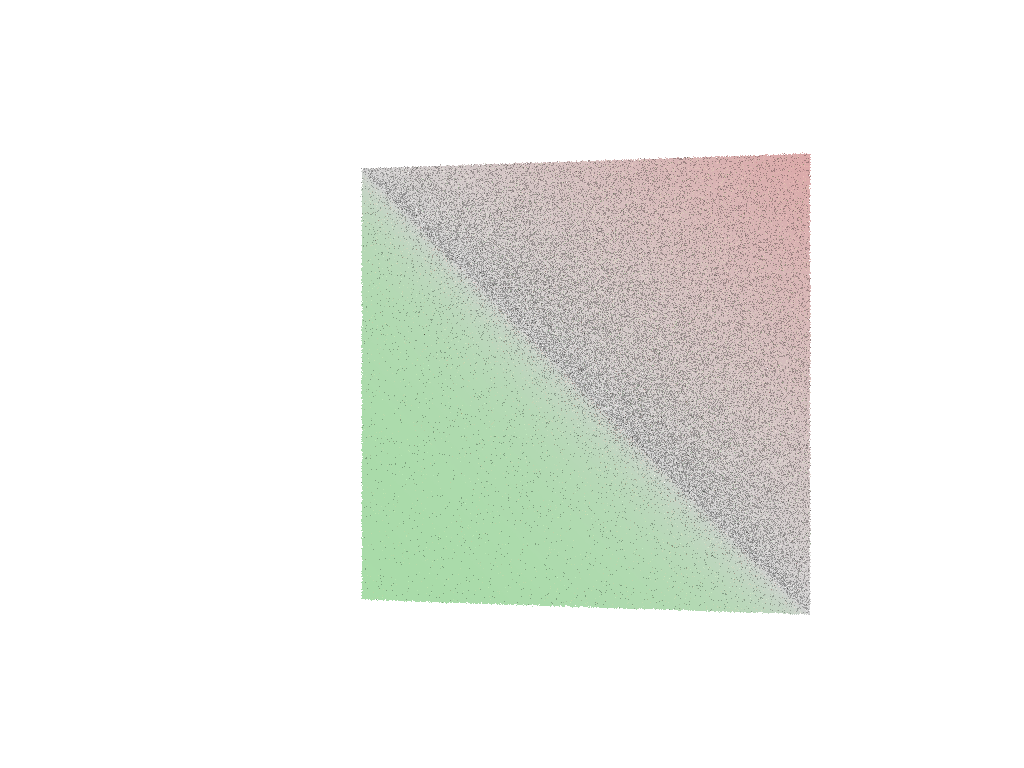

In [4]:
from IPython.display import Image
Image("firstFrame.png")

***
## Summary

You have arrived at the end of this lesson. During this lesson, you:

* Defined what Intel® OSPRay is about.
* Defined the goals of Intel® OSPRay.
* Summarized the program flow and OSPRay API to write a minimal viewer program for displaying mesh geometry.

***
## Resources
* M. Pharr and G. Humphreys. Physically Based Rendering: From Theory to Implementation. Morgan Kaufman, 3rd edition, 2016.
* P. Shirley. Ray Tracing in One Weekend Series. Editors: Steve Hollasch, Trevor David Black. Version/Edition: v3.2.0. Date: 2020-07-18. URL (series): https://raytracing.github.io/
* I. Wald et al., "OSPRay - A CPU Ray Tracing Framework for Scientific Visualization," in IEEE Transactions on Visualization and Computer Graphics, vol. 23, no. 1, pp. 931-940, Jan. 2017, doi: 10.1109/TVCG.2016.2599041.

***
<html><body><span style="color:green"><h1>Next: An Example of Intel® OSPRay Techniques and Procedural Scenes</h1></span></body></html>

[Click Here](../osp2_ospExamples/ospExamples.ipynb)

<html><body><span style="color:green"><h1>Back: Overview</h1></span></body></html>

[Click Here](../Overview.ipynb)